In [ ]:
import os
from typing import Any, Dict, Generator, List, Optional, Tuple, Union
from urllib import request

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import rdkit
import seaborn as sns
import shap
from boruta import BorutaPy
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.AllChem import (
    GetHashedMorganFingerprint,
    GetMorganFingerprintAsBitVect,
)
from rdkit.Chem.PandasTools import LoadSDF
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_predict
from tqdm.notebook import tqdm, trange

mpl.__version__


'3.5.2'

In [2]:
SEED = 334


In [3]:
rdkit.rdBase.rdkitVersion


'2022.03.3'

In [ ]:
url_sdf = "http://datachemeng.wp.xdomain.jp/wp-content/uploads/2017/04/logSdataset1290_2d.sdf"
# download and create cache
dirpath_cache = os.path.abspath("./cache")
if not os.path.isdir(dirpath_cache):
    os.mkdir(dirpath_cache)
fpath_sdf_cached = os.path.join(dirpath_cache, os.path.basename(url_sdf))
if not os.path.isfile(fpath_sdf_cached):
    with (
        request.urlopen(url_sdf) as response,
        open(fpath_sdf_cached, mode="w", encoding="utf-8") as out_file,
    ):
        data = response.read().decode("utf-8")
        out_file.write(data)


,CAS_Number,logS,ID,ROMol,CA_Number
0,60-35-5,1.58,CC(N)=O,,NaN
1,NaN,1.34,CNN,,60-34-4
2,NaN,1.22,CC(O)=O,,64-19-7
3,NaN,1.15,C1CCCN1,,123-75-1
4,NaN,1.12,NC([NH]O)=O,,127-07-1

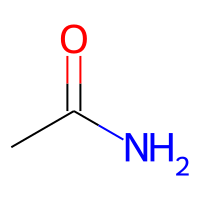
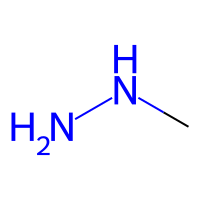
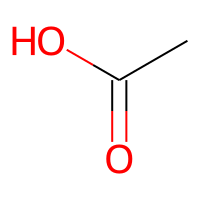
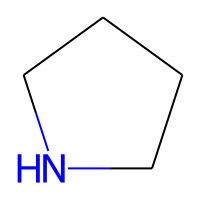
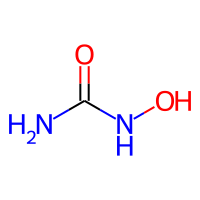

In [5]:
df: pd.DataFrame = LoadSDF(fpath_sdf_cached)
df.head()


In [6]:
target_col = "logS"
col_smiles = "SMILES"


SMILESに変換して重複を削除してキーにする。

,logS,ROMol
SMILES,,
Br/C=C\Br,-1.32,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
BrC(Br)(Br)Br,-3.14,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
BrC(Br)Br,-1.91,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
BrC1CCCCC1,-2.30,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
BrCBr,-1.17,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

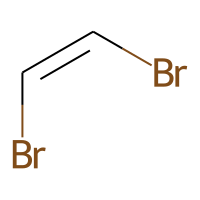
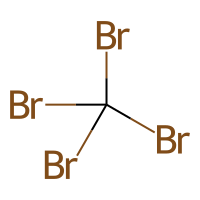
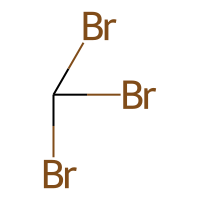
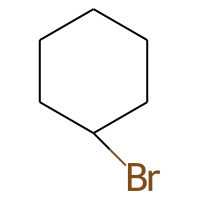
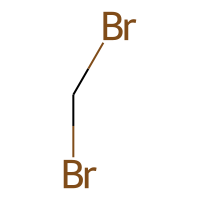

In [7]:
df[col_smiles] = df["ROMol"].apply(Chem.MolToSmiles)
df[target_col] = df[target_col].astype(float)

df_extracted = pd.concat(
    [
        df[[col_smiles, target_col]].groupby(col_smiles).mean(),
        df[[col_smiles, "ROMol"]].groupby(col_smiles).first(),
    ],
    axis=1,
)
df_extracted.head()


In [8]:
bitinfos: List[Dict[int, Tuple]] = []
fps: List[rdkit.DataStructs.cDataStructs.ExplicitBitVect] = []
for _mol in df_extracted["ROMol"]:
    bitinfo: Dict[int, Tuple] = {}
    fp = np.array(
        GetMorganFingerprintAsBitVect(
            _mol, radius=2, nBits=1024, bitInfo=bitinfo
        ),
        dtype=int,
    )
    bitinfos.append(bitinfo)
    fps.append(fp)
X: pd.DataFrame = pd.DataFrame(np.vstack(fps), index=df_extracted.index)
X.shape


(1286, 1024)

In [9]:
y = df_extracted[target_col]
y.shape


(1286,)

In [10]:
vselector = VarianceThreshold(threshold=0.0)
vselector.fit(X, y)
X_vselected: pd.DataFrame = X.iloc[:, vselector.get_support()]
X_vselected.shape


(1286, 1012)

In [11]:
feature_selector = BorutaPy(
    RandomForestRegressor(n_jobs=-1),
    n_estimators="auto",
    verbose=0,
    perc=80,
    random_state=SEED,
    max_iter=100,
)
feature_selector.fit(X_vselected.values, y)
X_selected: pd.DataFrame = X_vselected.iloc[:, feature_selector.support_]
X_selected.shape


(1286, 185)

In [12]:
estimator = RandomForestRegressor(random_state=334, n_jobs=-1)
estimator.fit(X_selected, y)
y_oof = cross_val_predict(
    estimator,
    X_selected,
    y,
    cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
    n_jobs=-1,
)


In [ ]:
# true vs pred
def plot_true_vs_pred(
    y: Union[pd.Series, np.ndarray], y_pred: Union[pd.Series, np.ndarray]
) -> None:
    sns.set_style("darkgrid")

    fig, ax = plt.subplots(facecolor="w")

    _tmp = np.hstack([np.array(y).ravel(), np.array(y_pred).ravel()])
    _range = (min(_tmp), max(_tmp))
    alpha = 0.05
    offset = (max(_range) - min(_range)) * alpha
    _plot_range = (min(_tmp) - offset, max(_tmp) + offset)

    ax.plot(*[_plot_range] * 2, color="gray", zorder=1)
    ax.scatter(y, y_pred, marker="o", s=10, alpha=0.5)

    ax.set_xlabel("$y_{true}$")
    ax.set_ylabel("$y_{pred}$")

    ax.set_xlim(_plot_range)
    ax.set_ylim(_plot_range)

    ax.text(
        min(_range),
        max(_range),
        f"$R^2={r2_score(y, y_pred):.2g}$\nRMSE$={mean_squared_error(y, y_pred, squared=False):.2f}$",
        ha="left",
        va="top",
    )

    ax.set_aspect("equal")
    fig.tight_layout()


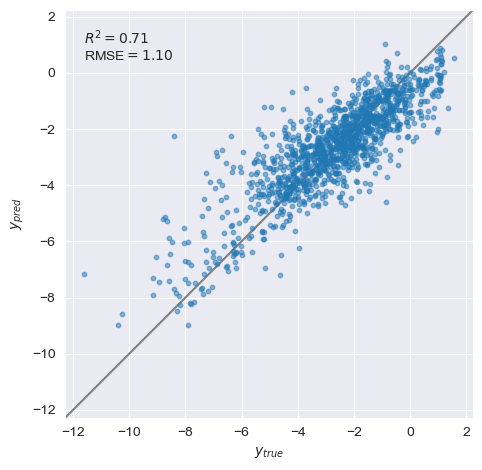

In [14]:
plot_true_vs_pred(y, y_oof)


In [15]:
estimator = clone(estimator).fit(X_selected, y)


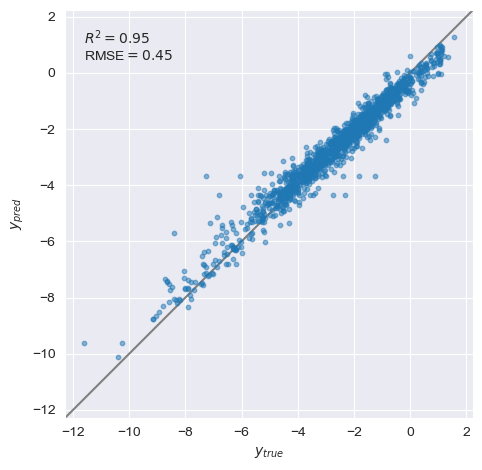

In [16]:
y_pred = estimator.predict(X_selected)
plot_true_vs_pred(y, y_pred)


In [17]:
# explainer = shap.LinearExplainer(model, X_selected)
explainer = shap.TreeExplainer(estimator, X_selected)
shap_values = pd.DataFrame(
    explainer.shap_values(X_selected),
    index=X_selected.index,
    columns=X_selected.columns,
)


 99%|===================| 1273/1286 [00:31<00:00]        

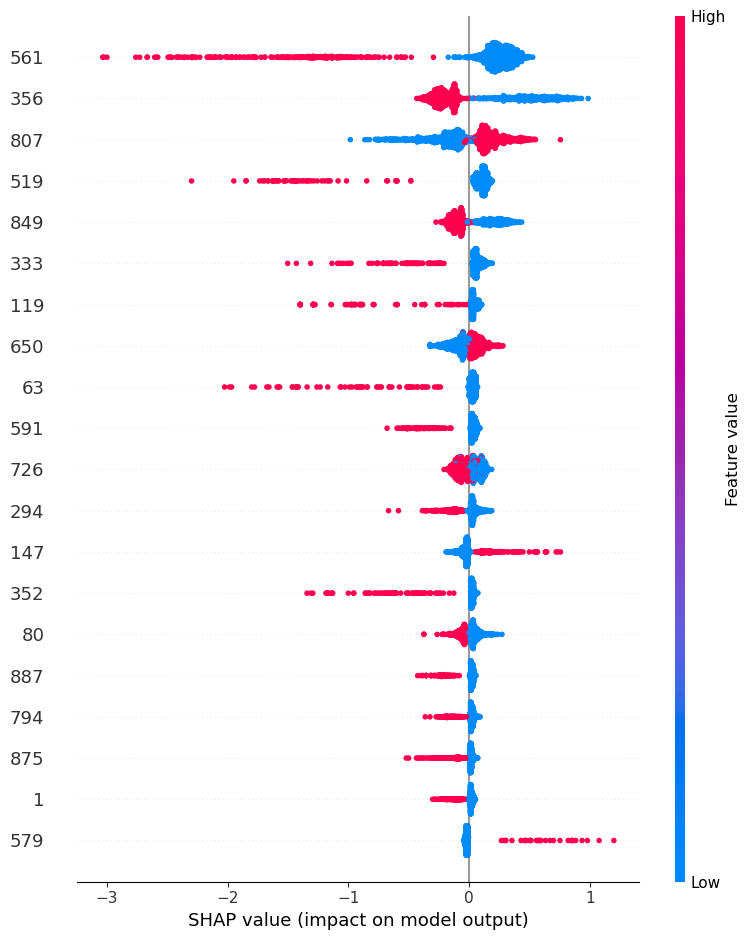

In [18]:
plt.rcParams.update(plt.rcParamsDefault)
shap.summary_plot(shap_values.values, X_selected, plot_type="dot")


In [19]:
# shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values[0], matplotlib=True)


In [20]:
shap_values.shape


(1286, 185)


$$
A_i = \sum_{n=1}^{N} \left( C_n \times \frac{1}{f_n} \times \frac{1}{x_n} \right)
$$

* $C_n$: 各フィンガープリントの寄与
* $f_n$: 分子中に含まれる各部分構造の数 ($n = 1, 2, \ldots, N$)
* $x_n$: 各部分構造に含まれる原子数

  0%|          | 0/5 [00:00<?, ?it/s]

{63: ((2, 2),), 64: ((0, 1), (1, 1)), 81: ((6, 1),), 90: ((8, 0),), 119: ((9, 1),), 175: ((1, 2), (0, 2)), 203: ((4, 2),), 291: ((5, 2),), 314: ((7, 1),), 356: ((3, 0), (6, 0), (9, 0)), 587: ((6, 2),), 650: ((7, 0),), 721: ((8, 1),), 726: ((2, 1), (4, 1), (5, 1), (10, 1)), 759: ((10, 2),), 793: ((9, 2),), 831: ((3, 1),), 849: ((0, 0), (1, 0), (2, 0), (4, 0), (5, 0), (10, 0)), 926: ((3, 2),), 951: ((8, 2),)}


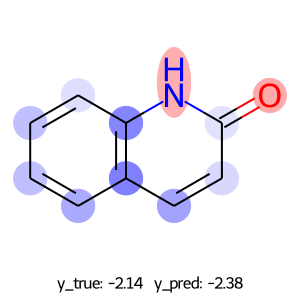

{15: ((3, 2), (10, 2)), 31: ((2, 2), (11, 2)), 33: ((0, 0), (14, 0)), 64: ((3, 1), (10, 1)), 228: ((7, 2),), 322: ((5, 1), (8, 1)), 346: ((5, 2), (8, 2)), 356: ((1, 0), (5, 0), (8, 0), (12, 0)), 562: ((4, 2), (9, 2)), 593: ((7, 1),), 610: ((6, 2), (13, 2)), 695: ((7, 0),), 698: ((0, 1), (14, 1)), 726: ((2, 1), (4, 1), (9, 1), (11, 1)), 799: ((1, 1), (12, 1)), 849: ((2, 0), (3, 0), (4, 0), (6, 0), (9, 0), (10, 0), (11, 0), (13, 0)), 875: ((6, 1), (13, 1)), 1013: ((1, 2), (12, 2))}


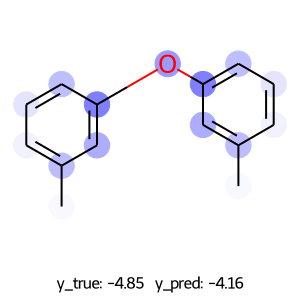

{1: ((1, 0),), 7: ((1, 2),), 42: ((10, 2), (14, 2)), 64: ((4, 1), (5, 1), (6, 1), (11, 1), (12, 1), (13, 1)), 79: ((8, 1),), 80: ((8, 0),), 175: ((4, 2), (6, 2), (11, 2), (13, 2)), 227: ((0, 1),), 263: ((2, 2),), 338: ((1, 1), (8, 2)), 341: ((2, 1),), 356: ((2, 0), (9, 0)), 389: ((5, 2), (12, 2)), 557: ((3, 2), (7, 2)), 726: ((3, 1), (7, 1), (10, 1), (14, 1)), 730: ((9, 1),), 807: ((0, 0),), 849: ((3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0)), 857: ((9, 2),)}


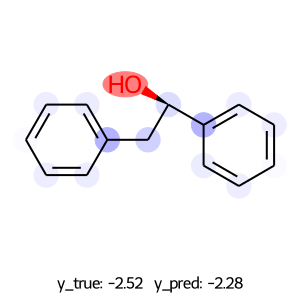

{33: ((0, 0),), 128: ((1, 1),), 134: ((4, 2),), 145: ((2, 1),), 147: ((7, 0),), 216: ((9, 1),), 352: ((11, 2),), 356: ((3, 0), (4, 0), (6, 0), (9, 0)), 433: ((7, 1),), 486: ((3, 2),), 561: ((5, 1), (10, 1)), 650: ((12, 0),), 659: ((5, 0), (10, 0)), 665: ((8, 2),), 669: ((6, 2),), 695: ((1, 0),), 723: ((9, 2),), 807: ((2, 0),), 841: ((0, 1),), 849: ((8, 0), (11, 0)), 875: ((8, 1), (11, 1)), 893: ((12, 1),), 906: ((1, 2),), 910: ((6, 1),), 936: ((2, 2),), 967: ((3, 1),), 1011: ((4, 1),)}


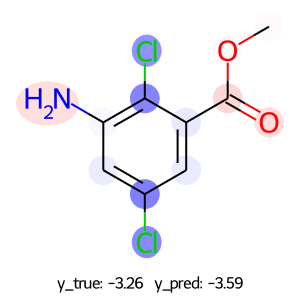

{33: ((0, 0), (2, 0), (7, 0)), 80: ((4, 0), (5, 0)), 101: ((4, 2),), 114: ((6, 0),), 233: ((1, 1),), 284: ((5, 1),), 342: ((10, 0),), 392: ((7, 1),), 401: ((4, 1),), 461: ((9, 1),), 479: ((3, 1),), 550: ((3, 2),), 558: ((1, 2),), 621: ((10, 1),), 694: ((3, 0), (9, 0)), 698: ((6, 1),), 807: ((1, 0), (8, 0)), 884: ((8, 1),), 906: ((9, 2),), 973: ((5, 2),), 975: ((6, 2),), 1017: ((0, 1), (2, 1))}


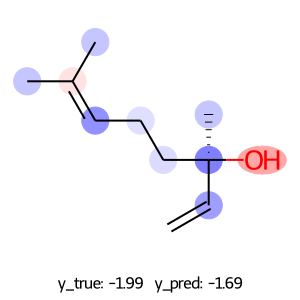

In [ ]:
selected_bit_num = X_selected.columns.tolist()

# i = 1
# for i in trange(X_selected.shape[0]):    # samples
# for i in trange(10):    # samples
rng_ = np.random.RandomState(SEED)
for i in tqdm(rng_.randint(0, X_selected.shape[0], 5)):
    bitinfo = bitinfos[i]
    # ratio_contribution = model.coef_[i] # C_n
    ratio_contributions: pd.Series = shap_values.iloc[i]  # C_n
    print(ratio_contributions)
    mol = df_extracted["ROMol"][i]

    bit_list = list(set(bitinfo.keys()) & set(selected_bit_num))

    importance_atoms = np.zeros(mol.GetNumAtoms(), dtype=float)
    for _bit in bit_list:
        n_substructure = len(bitinfo[_bit])
        ratio_contribution = ratio_contributions[_bit]
        for i_atom, radius in bitinfo[_bit]:
            if radius == 0:
                n_atom_in_substructure = 1
                importance_atoms[i_atom] += (
                    ratio_contribution
                    / n_atom_in_substructure
                    / n_substructure
                )
            else:
                atom_map = {}
                env = Chem.FindAtomEnvironmentOfRadiusN(
                    mol, radius=radius, rootedAtAtom=i_atom
                )
                submol = Chem.PathToSubmol(mol, env, atomMap=atom_map)

                n_atom_in_substructure = len(submol.GetAtoms())
                for j_atom in atom_map:
                    importance_atoms[j_atom] += (
                        ratio_contribution / n_atom_in_substructure
                    )

    # scaling
    importance_atoms_scaled = (
        importance_atoms / abs(importance_atoms).max() * 0.5
    )
    importance_atoms_scaled

    atom_colors = {
        i: (1, 1 - importance_atoms_scaled[i], 1 - importance_atoms_scaled[i])
        if importance_atoms_scaled[i] > 0
        else (
            1 + importance_atoms_scaled[i],
            1 + importance_atoms_scaled[i],
            1,
        )
        for i in range(len(importance_atoms_scaled))
    }

    view = Draw.rdMolDraw2D.MolDraw2DSVG(300, 300)
    tm = Draw.rdMolDraw2D.PrepareMolForDrawing(mol)
    view.DrawMolecule(
        tm,
        highlightAtoms=atom_colors.keys(),
        highlightAtomColors=atom_colors,
        highlightBonds=[],
        highlightBondColors={},
        legend=f"y_true: {y[i]:.2f}  y_pred: {y_pred[i]:.2f}",
    )
    view.FinishDrawing()
    svg = view.GetDrawingText()
    with open("highlighted_sample.svg", "w") as f:
        f.write(svg)
    display(SVG(svg))


In [ ]:
selected_bit_num = X_selected.columns.tolist()

# i = 1
# for i in trange(X_selected.shape[0]):    # samples
# for i in trange(10):    # samples
rng_ = np.random.RandomState(SEED)
for i in tqdm(rng_.randint(0, X_selected.shape[0], 5)):
    bitinfo = bitinfos[i]
    # ratio_contribution = model.coef_[i] # C_n
    ratio_contributions: pd.Series = shap_values.iloc[i]  # C_n
    mol = df_extracted["ROMol"][i]


def visualize_importance_atoms():
    bit_list = list(set(bitinfo.keys()) & set(selected_bit_num))

    importance_atoms = np.zeros(mol.GetNumAtoms(), dtype=float)
    for _bit in bit_list:
        n_substructure = len(bitinfo[_bit])
        ratio_contribution = ratio_contributions[_bit]
        for i_atom, radius in bitinfo[_bit]:
            if radius == 0:
                n_atom_in_substructure = 1
                importance_atoms[i_atom] += (
                    ratio_contribution
                    / n_atom_in_substructure
                    / n_substructure
                )
            else:
                atom_map = {}
                env = Chem.FindAtomEnvironmentOfRadiusN(
                    mol, radius=radius, rootedAtAtom=i_atom
                )
                submol = Chem.PathToSubmol(mol, env, atomMap=atom_map)

                n_atom_in_substructure = len(submol.GetAtoms())
                for j_atom in atom_map:
                    importance_atoms[j_atom] += (
                        ratio_contribution / n_atom_in_substructure
                    )

    # scaling
    importance_atoms_scaled = (
        importance_atoms / abs(importance_atoms).max() * 0.5
    )
    importance_atoms_scaled

    atom_colors = {
        i: (1, 1 - importance_atoms_scaled[i], 1 - importance_atoms_scaled[i])
        if importance_atoms_scaled[i] > 0
        else (
            1 + importance_atoms_scaled[i],
            1 + importance_atoms_scaled[i],
            1,
        )
        for i in range(len(importance_atoms_scaled))
    }

    view = Draw.rdMolDraw2D.MolDraw2DSVG(300, 300)
    tm = Draw.rdMolDraw2D.PrepareMolForDrawing(mol)
    view.DrawMolecule(
        tm,
        highlightAtoms=atom_colors.keys(),
        highlightAtomColors=atom_colors,
        highlightBonds=[],
        highlightBondColors={},
        legend=f"y_true: {y[i]:.2f}  y_pred: {y_pred[i]:.2f}",
    )
    view.FinishDrawing()
    svg = view.GetDrawingText()
    with open("highlighted_sample.svg", "w") as f:
        f.write(svg)
    display(SVG(svg))
